In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import time
import datetime
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Stopwords indirme
print("Stopwords indiriliyor...")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Veriyi Yükle
print("Veri yükleniyor...")
imdb_data = pd.read_csv("IMDB Dataset.csv")
print(f"Toplam yorum: {len(imdb_data)}")

Kullanılan cihaz: cuda
Stopwords indiriliyor...
Veri yükleniyor...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Toplam yorum: 50000


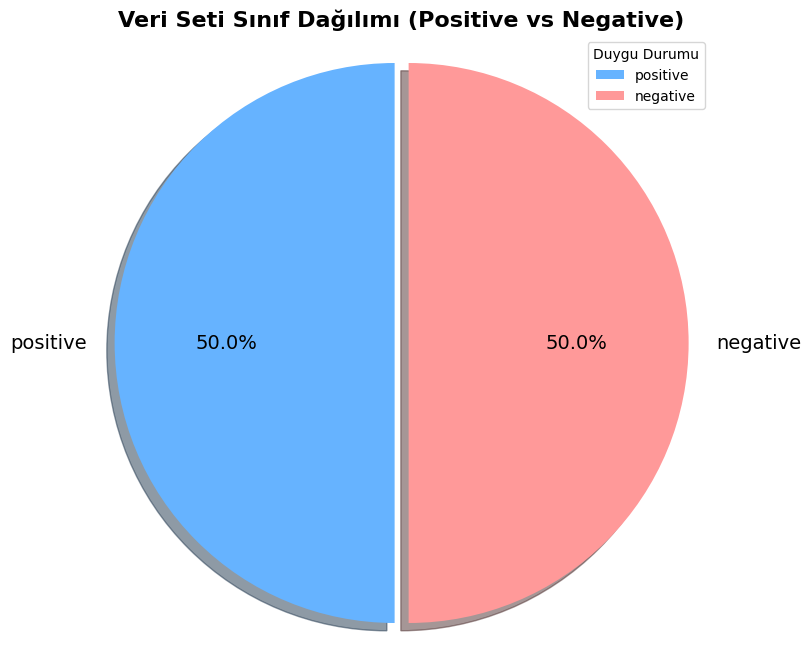

Pozitif Yorum Sayısı: 25000
Negatif Yorum Sayısı: 25000


In [ ]:
label_counts = imdb_data['sentiment'].value_counts()
plt.figure(figsize=(8, 8))
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)
plt.pie(label_counts,
        labels=label_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        explode=explode,
        shadow=True,
        textprops={'fontsize': 14})

plt.title('Veri Seti Sınıf Dağılımı (Positive vs Negative)', fontsize=16, fontweight='bold')
plt.legend(title="Duygu Durumu", loc="upper right")
plt.axis('equal')
plt.show()

print(f"Pozitif Yorum Sayısı: {label_counts['positive']}")
print(f"Negatif Yorum Sayısı: {label_counts['negative']}")

In [ ]:
# Temizleme Fonksiyonu
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Veriler temizleniyor...")
imdb_data['cleaned_review'] = imdb_data['review'].apply(clean_text)
imdb_data['label'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})

X = imdb_data['cleaned_review']
y = imdb_data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Eğitim Seti: {len(X_train)}")
print(f"Test Seti: {len(X_test)}")

Veriler temizleniyor...
Eğitim Seti: 40000
Test Seti: 10000


In [ ]:
# LSTM ve CNN İçin Hazırlık
def build_vocab_and_sequences(texts, max_words=20000):
    word_freq = {}
    for text in texts:
        for word in text.split():
            if word not in stop_words:
                word_freq[word] = word_freq.get(word, 0) + 1

    # Kelimeleri sıklığına göre sırala
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:max_words]

    # Sözlük oluştur
    vocab = {word: i+1 for i, (word, count) in enumerate(sorted_words)}
    vocab['<UNK>'] = len(vocab) + 1

    sequences = []
    for text in texts:
        seq = [vocab.get(word, vocab['<UNK>']) for word in text.split() if word in vocab or word == '<UNK>']
        sequences.append(seq)

    return vocab, sequences, sorted_words

print("LSTM/CNN için veriler hazırlanıyor...")

vocab, X_train_seq, sorted_words = build_vocab_and_sequences(X_train)

X_test_seq = []
for text in X_test:
    seq = [vocab.get(word, vocab['<UNK>']) for word in text.split() if word in vocab]
    X_test_seq.append(seq)

def pad_sequences_manual(sequences, max_len=256):
    features = np.zeros((len(sequences), max_len), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:max_len]
    return features

X_train_padded = pad_sequences_manual(X_train_seq, max_len=256)
X_test_padded = pad_sequences_manual(X_test_seq, max_len=256)

# LSTM/CNN DataLoader
train_data_classic = TensorDataset(torch.from_numpy(X_train_padded), torch.from_numpy(y_train))
test_data_classic = TensorDataset(torch.from_numpy(X_test_padded), torch.from_numpy(y_test))
train_loader_classic = DataLoader(train_data_classic, shuffle=True, batch_size=64)
test_loader_classic = DataLoader(test_data_classic, shuffle=False, batch_size=64)


# BERT ve XLNet İçin Hazırlık
print("\nTransformer modelleri için veri hazırlanıyor...")

def prepare_transformer_data(texts, labels, tokenizer_cls, model_name, max_len=128):
    tokenizer = tokenizer_cls.from_pretrained(model_name)

    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

# BERT Data
print("BERT verisi hazırlanıyor...")
train_dataset_bert = prepare_transformer_data(X_train, y_train, BertTokenizer, 'bert-base-uncased')
test_dataset_bert = prepare_transformer_data(X_test, y_test, BertTokenizer, 'bert-base-uncased')

# XLNet Data
print("XLNet verisi hazırlanıyor...")
train_dataset_xlnet = prepare_transformer_data(X_train, y_train, XLNetTokenizer, 'xlnet-base-cased')
test_dataset_xlnet = prepare_transformer_data(X_test, y_test, XLNetTokenizer, 'xlnet-base-cased')

# Dataloaders
batch_size_trans = 16
train_loader_bert = DataLoader(train_dataset_bert, shuffle=True, batch_size=batch_size_trans)
test_loader_bert = DataLoader(test_dataset_bert, shuffle=False, batch_size=batch_size_trans)

train_loader_xlnet = DataLoader(train_dataset_xlnet, shuffle=True, batch_size=batch_size_trans)
test_loader_xlnet = DataLoader(test_dataset_xlnet, shuffle=False, batch_size=batch_size_trans)

print("Tüm DataLoader'lar hazır.")

LSTM/CNN için veriler hazırlanıyor...

Transformer modelleri için veri hazırlanıyor...
BERT verisi hazırlanıyor...
XLNet verisi hazırlanıyor...
Tüm DataLoader'lar hazır.


In [ ]:
# 1. LSTM Model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, mask=None):
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds)
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return self.sigmoid(out)

# 2. CNN Model
class SentimentCNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim):
        super(SentimentCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 100, kernel_size=3)
        self.conv2 = nn.Conv1d(embedding_dim, 100, kernel_size=4)
        self.conv3 = nn.Conv1d(embedding_dim, 100, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x1 = self.pool(torch.relu(self.conv1(x))).squeeze(-1)
        x2 = self.pool(torch.relu(self.conv2(x))).squeeze(-1)
        x3 = self.pool(torch.relu(self.conv3(x))).squeeze(-1)
        x_concat = torch.cat((x1, x2, x3), dim=1)
        out = self.dropout(x_concat)
        out = self.fc(out)
        return self.sigmoid(out)

# 3. BERT Model Wrapper
class SentimentBERT(nn.Module):
    def __init__(self):
        super(SentimentBERT, self).__init__()
        # Önceden eğitilmiş 'bert-base-uncased' modelini indirir
        self.bert = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",
            num_labels=1,
            output_attentions=False,
            output_hidden_states=False
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return self.sigmoid(logits)

# 4. XLNet Model Wrapper
class SentimentXLNet(nn.Module):
    def __init__(self):
        super(SentimentXLNet, self).__init__()
        self.xlnet = XLNetForSequenceClassification.from_pretrained(
            "xlnet-base-cased",
            num_labels=1
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.xlnet(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return self.sigmoid(logits)

print("Tüm Modeller (LSTM, CNN, BERT, XLNet) tanımlandı.")

Tüm Modeller (LSTM, CNN, BERT, XLNet) tanımlandı.


In [ ]:
def train_model(model, train_loader, epochs=1, lr=0.001, is_transformer=False):
    if is_transformer:
        # Transformerlar için özel optimizer (AdamW)
        optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    else:
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)
    print(f"\n--- {type(model).__name__} Eğitiliyor... ---")

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            model.zero_grad()

            if len(batch) == 3:
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device).float()

                output = model(b_input_ids, attention_mask=b_input_mask)
                loss = nn.BCELoss()(output.squeeze(), b_labels)

            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device).long(), labels.to(device).float()
                output = model(inputs)
                loss = nn.BCELoss()(output.squeeze(), labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradyan patlamasını önle
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} | Ortalama Loss: {avg_loss:.4f}")

    return model

In [ ]:
def get_predictions(model, loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3: # Transformer
                b_ids = batch[0].to(device)
                b_mask = batch[1].to(device)
                outputs = model(b_ids, attention_mask=b_mask)
            else: # Klasik
                inputs = batch[0].to(device).long()
                outputs = model(inputs)

            preds = torch.round(outputs.squeeze()).cpu().numpy()
            all_preds.extend(preds)

    return np.array(all_preds)

In [ ]:
vocab_size = len(vocab) + 2

# 1. LSTM EĞİTİMİ
print("=== LSTM Başlatılıyor ===")
model_lstm = SentimentLSTM(vocab_size, output_size=1, embedding_dim=100, hidden_dim=256, n_layers=2)
model_lstm = train_model(model_lstm, train_loader_classic, epochs=3, lr=0.001, is_transformer=False)

# 2. CNN EĞİTİMİ
print("=== CNN Başlatılıyor ===")
model_cnn = SentimentCNN(vocab_size, output_size=1, embedding_dim=100)
model_cnn = train_model(model_cnn, train_loader_classic, epochs=3, lr=0.001, is_transformer=False)

# 3. BERT EĞİTİMİ
print("=== BERT Başlatılıyor ===")
model_bert = SentimentBERT()
model_bert = train_model(model_bert, train_loader_bert, epochs=2, lr=2e-5, is_transformer=True)

# 4. XLNet EĞİTİMİ
print("=== XLNet Başlatılıyor ===")
model_xlnet = SentimentXLNet()
model_xlnet = train_model(model_xlnet, train_loader_xlnet, epochs=2, lr=2e-5, is_transformer=True)

print("\nTüm eğitimler başarıyla tamamlandı.")

=== LSTM Başlatılıyor ===

--- SentimentLSTM Eğitiliyor... ---
Epoch 1 | Ortalama Loss: 0.5621
Epoch 2 | Ortalama Loss: 0.3726
Epoch 3 | Ortalama Loss: 0.2864
=== CNN Başlatılıyor ===

--- SentimentCNN Eğitiliyor... ---
Epoch 1 | Ortalama Loss: 0.5643
Epoch 2 | Ortalama Loss: 0.4035
Epoch 3 | Ortalama Loss: 0.3359
=== BERT Başlatılıyor ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- SentimentBERT Eğitiliyor... ---
Epoch 1 | Ortalama Loss: 0.3154
Epoch 2 | Ortalama Loss: 0.1978
=== XLNet Başlatılıyor ===


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- SentimentXLNet Eğitiliyor... ---
Epoch 1 | Ortalama Loss: 0.2936
Epoch 2 | Ortalama Loss: 0.2098

Tüm eğitimler başarıyla tamamlandı.


In [ ]:
# Tahminleri Al
y_pred_lstm = get_predictions(model_lstm, test_loader_classic)
y_pred_cnn = get_predictions(model_cnn, test_loader_classic)
y_pred_bert = get_predictions(model_bert, test_loader_bert)
y_pred_xlnet = get_predictions(model_xlnet, test_loader_xlnet)

def get_summary_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score (Weighted)': f1_score(y_true, y_pred, average='weighted'),
        'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted')
    }

# Metrikleri Hesapla
metrics_lstm = get_summary_metrics(y_test, y_pred_lstm, 'LSTM')
metrics_cnn = get_summary_metrics(y_test, y_pred_cnn, 'CNN')
metrics_bert = get_summary_metrics(y_test, y_pred_bert, 'BERT')
metrics_xlnet = get_summary_metrics(y_test, y_pred_xlnet, 'XLNet')
metrics_log = {'Model': 'Logistic Regression', 'Accuracy': 0.8798, 'F1 Score (Weighted)': 0.8808,
               'Precision (Weighted)': 0.8735, 'Recall (Weighted)': 0.8882}

# Tabloyu Oluştur
df_general = pd.DataFrame([
    metrics_lstm,
    metrics_cnn,
    metrics_bert,
    metrics_xlnet,
    metrics_log,
    ]).set_index('Model')

def highlight_max_gen(s):
    is_max = s == s.max()
    return ['font-weight: bold; background-color: #66c2a5; color: black' if v else '' for v in is_max]

print("\n=== GENEL MODEL KARŞILAŞTIRMASI ===")
display(df_general.style.apply(highlight_max_gen))


=== GENEL MODEL KARŞILAŞTIRMASI ===


,Accuracy,F1 Score (Weighted),Precision (Weighted),Recall (Weighted)
Model,,,,
LSTM,0.871100,0.871086,0.871258,0.871100
CNN,0.865100,0.864568,0.870933,0.865100
BERT,0.898500,0.898379,0.900406,0.898500
XLNet,0.905600,0.905584,0.905874,0.905600
Logistic Regression,0.879800,0.880800,0.873500,0.888200


In [ ]:
models_preds = {
    'CNN': y_pred_cnn,
    'LSTM': y_pred_lstm,
    'BERT': y_pred_bert,
    'XLNet': y_pred_xlnet
}

# Önceki projeden alınan Lojistik Regresyon metrik değerleri
log_reg_data = {
    'Negative': {'p': 0.886289, 'r': 0.871400, 'f1': 0.878781},
    'Positive': {'p': 0.873524, 'r': 0.888200, 'f1': 0.880801}
}

class_metrics = []
classes = {'0': 'Negative', '1': 'Positive'}

for model_name, preds in models_preds.items():
    report = classification_report(y_test, preds, output_dict=True)
    for cls_key, cls_name in classes.items():
        class_metrics.append({
            'Sınıf': cls_name,
            'Model': model_name,
            'Precision': report[cls_key]['precision'],
            'Recall': report[cls_key]['recall'],
            'F1-Score': report[cls_key]['f1-score']
        })

for cls_key, cls_name in classes.items():
    class_metrics.append({
        'Sınıf': cls_name,
        'Model': 'Log Reg',
        'Precision': log_reg_data[cls_name]['p'],
        'Recall': log_reg_data[cls_name]['r'],
        'F1-Score': log_reg_data[cls_name]['f1']
    })

df_class_based = pd.DataFrame(class_metrics).set_index(['Sınıf', 'Model'])
print("\n=== SINIF BAZLI BAŞARIM (Transformerlar vs LSTM) ===")
display(df_class_based.style.background_gradient(cmap='Greens'))


=== SINIF BAZLI BAŞARIM (Transformerlar vs LSTM) ===


,,Precision,Recall,F1-Score
Sınıf,Model,,,
Negative,CNN,0.917448,0.802400,0.856076
Positive,CNN,0.824418,0.927800,0.873059
Negative,LSTM,0.878905,0.860800,0.869759
Positive,LSTM,0.863610,0.881400,0.872414
Negative,BERT,0.928034,0.864000,0.894873
Positive,BERT,0.872778,0.933000,0.901885
Negative,XLNet,0.916427,0.892600,0.904357
Positive,XLNet,0.895322,0.918600,0.906811
Negative,Log Reg,0.886289,0.871400,0.878781


Olasılık değerleri hesaplanıyor...
Tamamlandı.


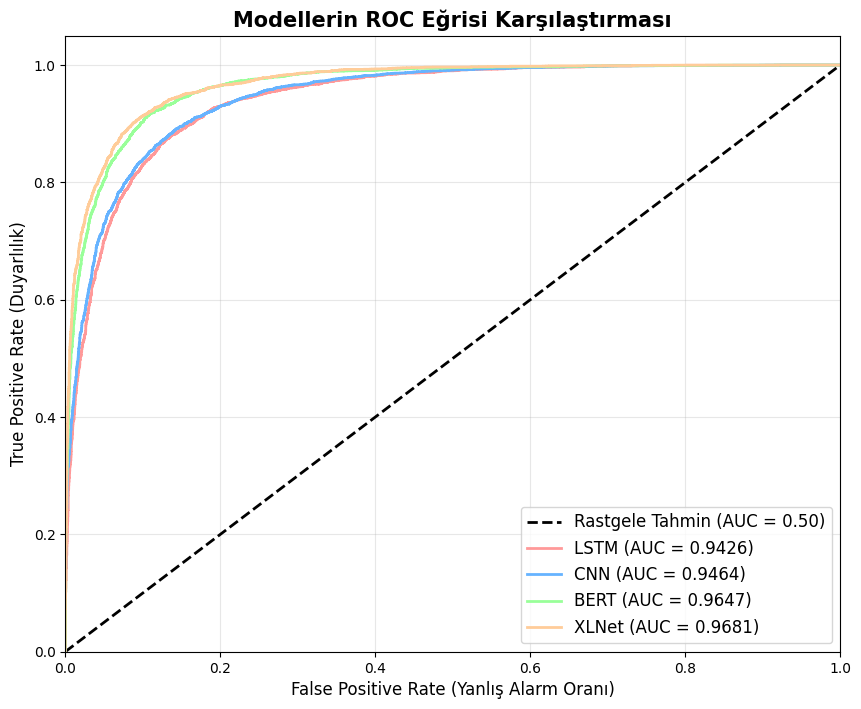

In [ ]:
from sklearn.metrics import roc_curve, auc

def get_probabilities(model, loader):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                b_ids = batch[0].to(device)
                b_mask = batch[1].to(device)
                outputs = model(b_ids, attention_mask=b_mask)
            else:
                inputs = batch[0].to(device).long()
                outputs = model(inputs)
            probs = outputs.squeeze().cpu().numpy()
            all_probs.extend(probs)

    return np.array(all_probs)

print("Olasılık değerleri hesaplanıyor...")
y_probs_lstm = get_probabilities(model_lstm, test_loader_classic)
y_probs_cnn = get_probabilities(model_cnn, test_loader_classic)
y_probs_bert = get_probabilities(model_bert, test_loader_bert)
y_probs_xlnet = get_probabilities(model_xlnet, test_loader_xlnet)
print("Tamamlandı.")

# Grafik Ayarları
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele Tahmin (AUC = 0.50)') # Köşegen çizgi

models_probs = {
    'LSTM': y_probs_lstm,
    'CNN': y_probs_cnn,
    'BERT': y_probs_bert,
    'XLNet': y_probs_xlnet
}

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
i = 0

for model_name, y_probs in models_probs.items():
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{model_name} (AUC = {roc_auc:.4f})')
    i += 1

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
plt.ylabel('True Positive Rate (Duyarlılık)', fontsize=12)
plt.title('Modellerin ROC Eğrisi Karşılaştırması', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

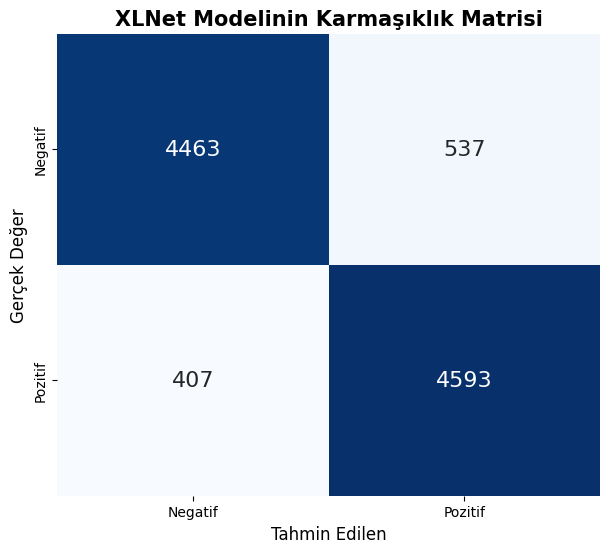

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# En iyi modelin tahminlerini kullanıyoruz (XLNet)
cm = confusion_matrix(y_test, y_pred_xlnet)

# Grafik Ayarları
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negatif', 'Pozitif'],
            yticklabels=['Negatif', 'Pozitif'],
            annot_kws={"size": 16})

plt.title('XLNet Modelinin Karmaşıklık Matrisi', fontsize=15, fontweight='bold')
plt.xlabel('Tahmin Edilen', fontsize=12)
plt.ylabel('Gerçek Değer', fontsize=12)
plt.show()

In [ ]:
results_df = pd.DataFrame({
    'Yorum': X_test,
    'Gerçek_Etiket': y_test,
    'Tahmin_XLNet': y_pred_xlnet
})

errors = results_df[results_df['Gerçek_Etiket'] != results_df['Tahmin_XLNet']]

print(f"Toplam Hatalı Tahmin Sayısı: {len(errors)}")
print("\n=== MODELİN YANILDIĞI 5 ÖRNEK ===")

for index, row in errors.sample(5).iterrows():
    true_label = "POZİTİF" if row['Gerçek_Etiket'] == 1 else "NEGATİF"
    pred_label = "POZİTİF" if row['Tahmin_XLNet'] == 1 else "NEGATİF"

    print(f"\n📝 Yorum: {row['Yorum'][:200]}...")
    print(f"✅ Gerçek: {true_label} | ❌ Tahmin: {pred_label}")
    print("-" * 50)

Toplam Hatalı Tahmin Sayısı: 944

=== MODELİN YANILDIĞI 5 ÖRNEK ===

📝 Yorum: why didnt the producers give that show a chance of all the junk on tv why didnt the producers give six degrees a chance will the series go on video i would love to see how it ends put season one on vi...
✅ Gerçek: POZİTİF | ❌ Tahmin: NEGATİF
--------------------------------------------------

📝 Yorum: s comedy mystery about the crooked circle a band of hooded crooks who set about plotting the murder of some one who swore to oppose them enjoyable but really unremarkable little film the movie works s...
✅ Gerçek: POZİTİF | ❌ Tahmin: NEGATİF
--------------------------------------------------

📝 Yorum: peter boyle was always a great actor and he proved it by his performance as a gunho bigot making me hate him everytime he used the n word i watched him and his big mouth and wanted to punch his lights...
✅ Gerçek: POZİTİF | ❌ Tahmin: NEGATİF
--------------------------------------------------

📝 Yorum: welcome to ou